# Depth Metrics

This repository/notebook aims to implement the affine invariant protocol for relative monocular depth estimation models

- Step 1: Load the data.

- Step 2: Pre-process: Transform into disparity, apply masks, deal with zero division.

- Step 3: Align the prediction with groundtruth with least squares algorithm

- Step 4: Calculate the Metrics (AbsRel, delta, RMSE)

- Step 5: Output the results in pandas dataframe and figures.  

### Coisas pra fazer:
- depth report
  - problema em alguns histogramas, mesmo capados (ex: 690)
  
- depth_info
  - mostrar o nome da variável 

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from utils import (get_sorted_files,  
                   compute_scale_and_shift, 
                   cap_values,   
                   depth_report, 
                   calculate_delta,
                   abs_rel_error_mask)


# Affine-Invariant Alignment

## 1. Load data

In [159]:
diode_path = Path("/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/")
diode_indoor = diode_path / "val" / "indoors"
diode_outdoor = diode_path / "val" / "outdoor"
diode_preds = Path("/home/gustavo/workstation/depth_estimation/data/outputs/DIODE-Anythingv2/npy/")

filenames_img = get_sorted_files(diode_path, ".png")
filenames_depth = get_sorted_files(diode_path, "_depth.npy")
filenames_mask = get_sorted_files(diode_path, "_depth_mask.npy")
filenames_preds_indoor = get_sorted_files(diode_preds, ".npy")

In [160]:
len(filenames_preds_indoor)

771

In [161]:
index = 585
pred_diode = np.load(filenames_preds_indoor[index])
groundtruth = np.squeeze(np.load(filenames_depth[index]))
rgb = np.array(Image.open(filenames_img[index]))
H,W = groundtruth.shape
mask = np.load(filenames_mask[index]).reshape((H, W))

## 2. Pre Processing

In [162]:
mask_pred = np.ones_like(pred_diode)
mask_pred[pred_diode < 10] = 0

mask_full = mask * mask_pred

In [163]:
gt_depth_masked = np.zeros_like(groundtruth)
gt_depth_masked[mask_full == 1] = groundtruth[mask_full == 1]

gt_disp_masked = np.zeros_like(groundtruth)
gt_disp_masked[mask_full == 1] = 1.0 / groundtruth[mask_full == 1]

pred_depth = np.zeros_like(groundtruth) 
pred_depth[mask_full == 1] = 1.0 / pred_diode[mask_full == 1]

gt_depth_capped = cap_values(groundtruth, 2, 98)
gt_disp_capped = cap_values(gt_disp_masked, 2, 98)

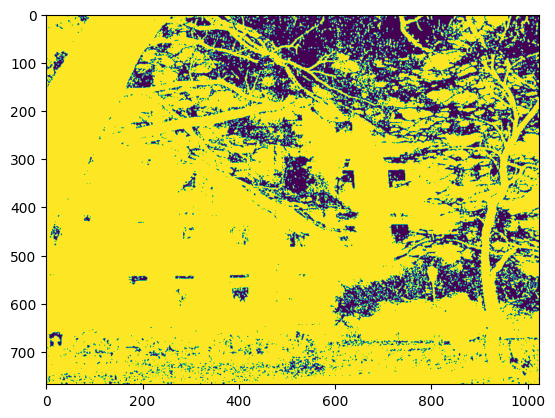

In [164]:
plt.imshow(mask)

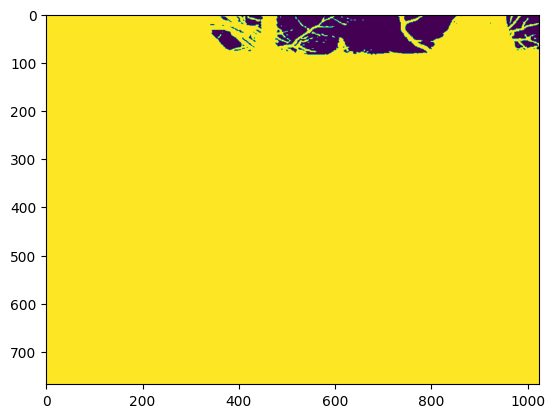

In [165]:
plt.imshow(mask_pred)

Visualization of the data 

- a) RGB Image
- b) Prediction from model in UINT8
- c) Groundtruth depth in UINT8
- d) Histogram from depth groundtruth

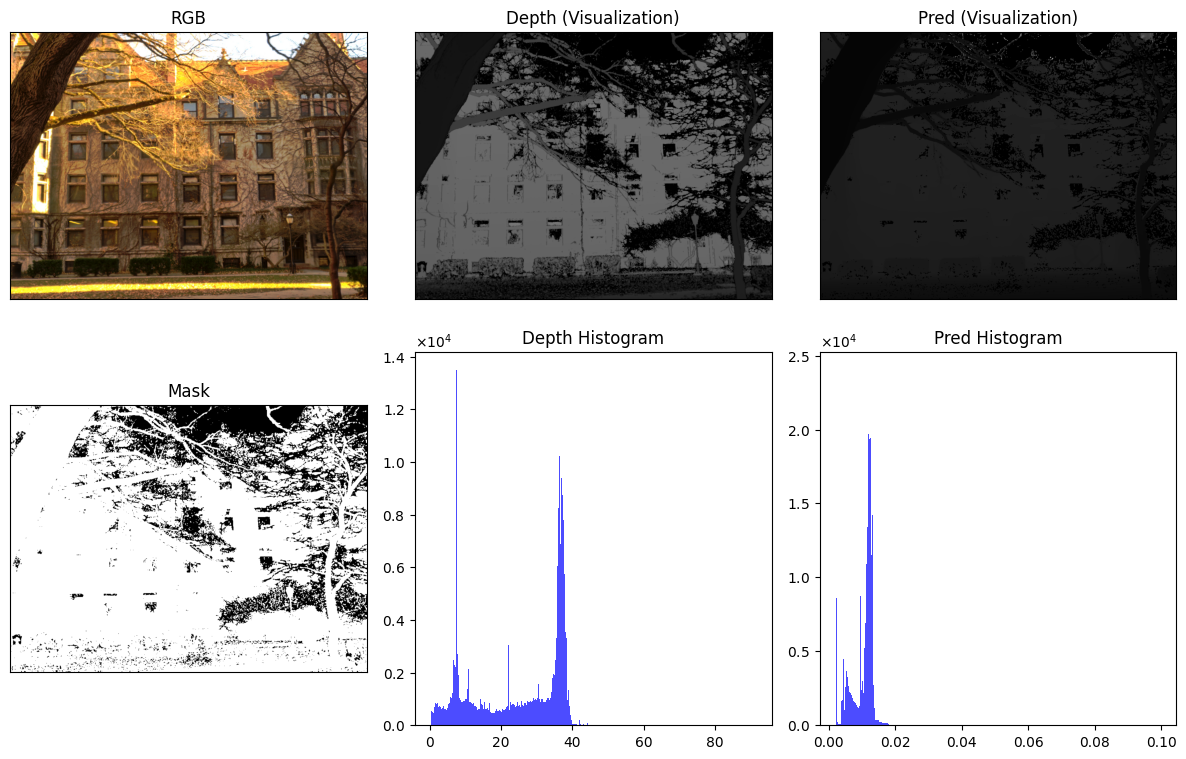

---- Depth Report ----

how many uniques: 584033
Max: 91.3553695678711
Min: 0.3000220060348511
Dtype: float32
---- Depth Report ----

how many uniques: 592811
Max: 0.09972192347049713
Min: 0.0020865732803940773
Dtype: float32


In [166]:
depth_report(rgb, gt_depth_masked, pred_depth, mask=mask_full)

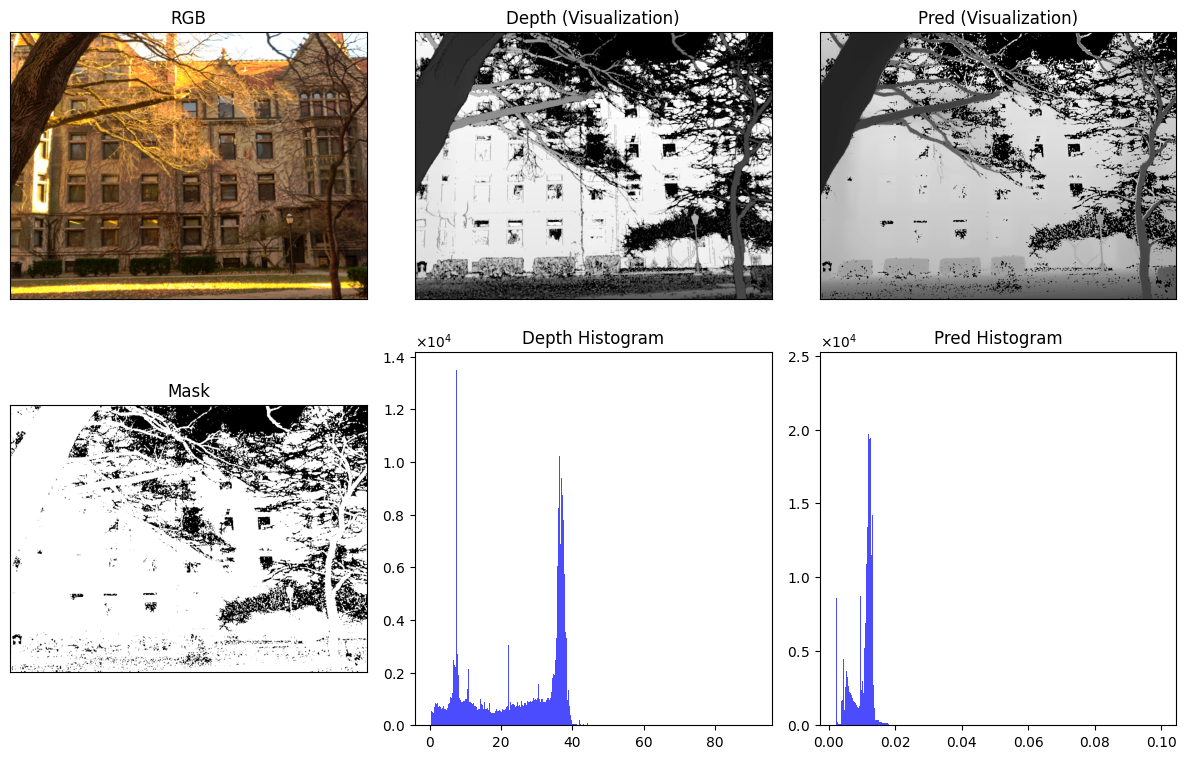

---- Depth Report ----

how many uniques: 584033
Max: 91.3553695678711
Min: 0.3000220060348511
Dtype: float32
---- Depth Report ----

how many uniques: 592811
Max: 0.09972192347049713
Min: 0.0020865732803940773
Dtype: float32


In [167]:
depth_report(rgb, gt_depth_masked, pred_depth*mask_full,mask=mask_full, cap=True, uint=True)

## 3. Alignment via least squares algorithm

In [168]:
x_0, x_1 = compute_scale_and_shift(pred_diode, gt_disp_masked, mask_full)

In [169]:
prediction_aligned = x_0 * pred_diode + x_1
prediction_aligned = np.squeeze(prediction_aligned)*mask_full

depth_aligned_masked = np.zeros_like(pred_diode)
depth_aligned_masked[mask_full == 1] = 1 / prediction_aligned[mask_full == 1]
depth_aligned_capped = cap_values(depth_aligned_masked, 2, 98)

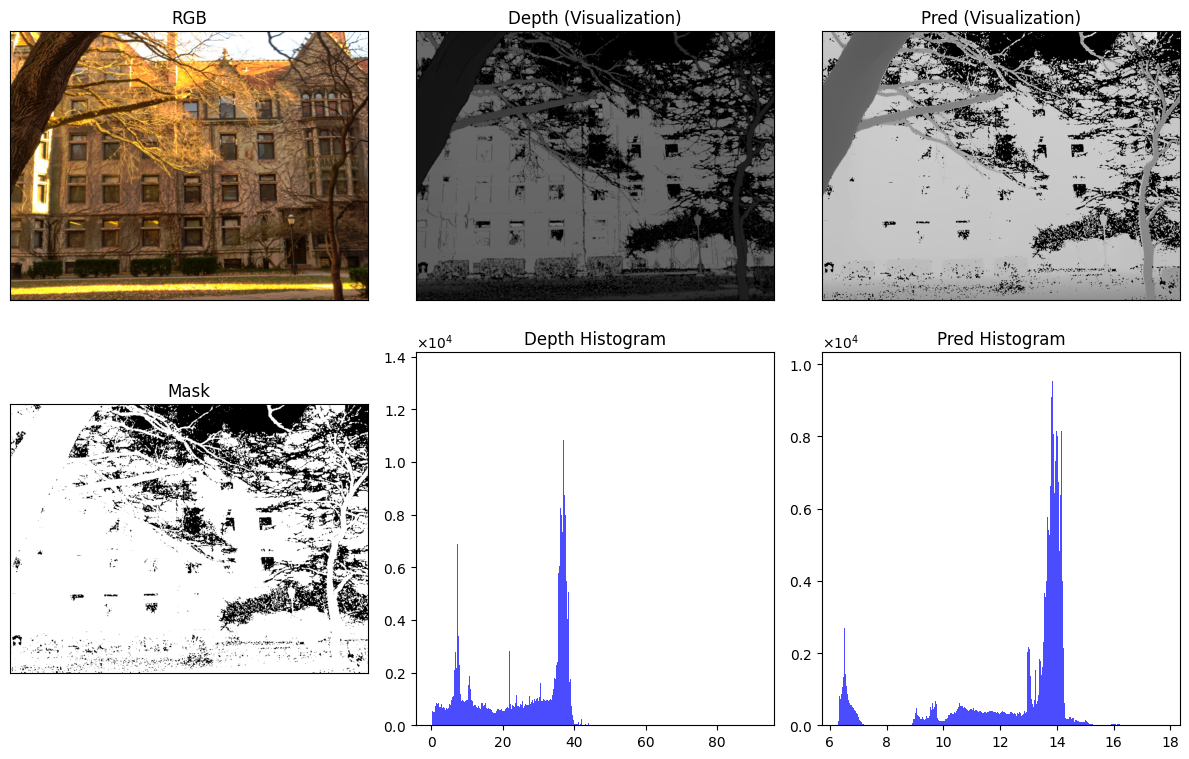

---- Depth Report ----

how many uniques: 584033
Max: 91.3553695678711
Min: 0.3000220060348511
Dtype: float32
---- Depth Report ----

how many uniques: 494058
Max: 17.763919830322266
Min: 6.297669887542725
Dtype: float32


In [170]:
depth_report(rgb, gt_depth_masked, depth_aligned_masked, mask=mask_full, cap=False, uint=False)

----------------

Visualization of a column of the groundtruth, and from the prediction. Then, align them both.

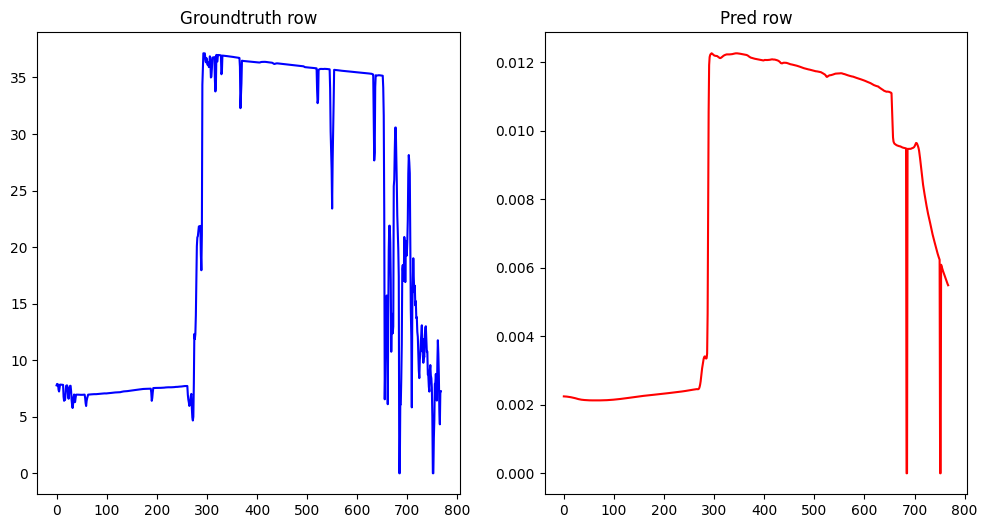

In [171]:
row_index = 100
GT_row = groundtruth[:, row_index]
pred_row = (pred_depth)[:, row_index]
pred_aligned_row = depth_aligned_capped[:, row_index]


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot( GT_row, 'b')
ax[0].set_title("Groundtruth row")
ax[1].plot(pred_row, 'r')
ax[1].set_title("Pred row")
plt.show()

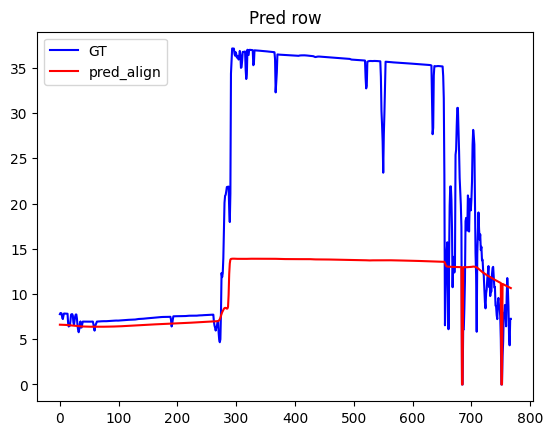

In [172]:
fig, ax = plt.subplots()
ax.plot(GT_row, 'b',label="GT")
ax.plot(pred_aligned_row, 'r', label="pred_align")
ax.set_title("Pred row")
ax.legend()
plt.show()

## 4. Calculate Metrics

### 4.1 metrics on groundtruth masked

In [173]:
abs_rel_error_mask(depth_aligned_masked, gt_depth_masked, mask_full)

np.float32(0.65807015)

In [174]:
calculate_delta(depth_aligned_masked, groundtruth, mask_full, threshold=1.25)

np.float64(17.32474207983897)

### 4.2 metrics on groundtruth capped

In [175]:
abs_rel_error_mask(depth_aligned_capped, gt_depth_capped,mask_full)

np.float32(0.6554005)

In [176]:
calculate_delta(depth_aligned_capped, gt_depth_capped, mask_full, threshold=1.25)

np.float64(17.321567189412377)

## 5. Output the results